In [2]:
!nvidia-smi

Sun Jun  4 06:19:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.156.00   Driver Version: 450.156.00   CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:07:00.0 Off |                    0 |
| N/A   27C    P0    61W / 400W |  39005MiB / 40537MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:0F:00.0 Off |                    0 |
| N/A   

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

# Import

In [4]:
!pip install -qq transformers
!pip install -qq nlpaug
!pip install -qq scikit-multilearn

In [5]:
import random
import numpy as np
import nlpaug.augmenter.word as naw
import torch
import torch.nn.functional as F
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel, get_constant_schedule_with_warmup
from transformers import TrainingArguments, Trainer, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [6]:
import pandas as pd
import xml.etree.ElementTree as ET
import re
import numpy as np
# import seaborn as sns
import warnings
import string
warnings.filterwarnings("ignore", 'This pattern has match groups')
import matplotlib.pyplot as plt
import matplotlib

In [7]:
seed_val = 1906350912
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

In [8]:
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [9]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('Tersedia sejumlah %d GPU(s).' % torch.cuda.device_count())
    print('GPU yang akan digunakan:', torch.cuda.get_device_name(0))
else:
    print('Tidak mendukung GPU; hanya CPU')
    device = torch.device("cpu")

Tersedia sejumlah 1 GPU(s).
GPU yang akan digunakan: A100-SXM4-40GB


In [10]:
df_train = pd.read_csv(f"Dataset/Human_Annotated.csv", index_col="ID")
df_train.fillna("", inplace = True)
# df_test = pd.read_csv(f"gold_standard.csv", index_col="ID").drop(columns=["Unnamed: 0"])
df_test = pd.read_csv(f"Dataset/Gold_Standard.csv", index_col="ID")
df_test.fillna("", inplace = True)
categories = ['Anak', 'Bedah', 'Gigi', 'Gizi', 'Jantung', 'Jiwa',
       'Kandungan', 'Kulit dan Kelamin', 'Mata', 'Paru', 'Penyakit Dalam',
       'Saraf', 'THT', 'Tulang', 'Urologi']

In [11]:
df_test['Count'] = df_test.drop(columns=['JUDUL', 'ISI']).values.sum(axis=1)
df_test = df_test[df_test['Count'] <= 3].drop(columns=['Count'])

In [12]:
df_train_umumnt = df_train.drop(columns=["Umum"])
df_train_umumnt["COUNT CLASS"] = df_train_umumnt.drop(columns=["JUDUL", "ISI"]).sum(axis=1)
df_train = df_train_umumnt[df_train_umumnt["COUNT CLASS"] > 0].drop(columns=["COUNT CLASS"])

In [13]:
df_test_umumnt = df_test.drop(columns=["Umum"])
df_test_umumnt["COUNT CLASS"] = df_test_umumnt.drop(columns=["JUDUL", "ISI"]).sum(axis=1)
df_test = df_test_umumnt[df_test_umumnt["COUNT CLASS"] > 0].drop(columns=["COUNT CLASS"])

<AxesSubplot:ylabel='Frequency'>

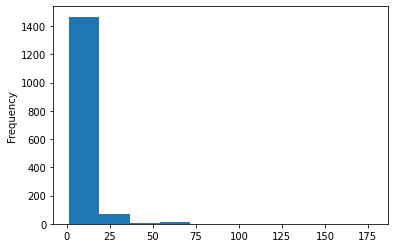

In [14]:
df_train['JUDUL'].str.split().str.len().plot.hist()

<AxesSubplot:ylabel='Frequency'>

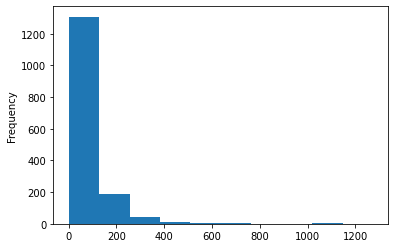

In [15]:
df_train['ISI'].str.split().str.len().plot.hist()

In [16]:
code = ['DS', 'AD', 'DH', 'TD', 'KD']
for i in code:
  df_train[i] = df_train.index.map(lambda x: 1 if x[:2] == i else 0)

X = df_train[['JUDUL', 'ISI']].values
y = df_train.drop(columns=['JUDUL', 'ISI']).values

from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_val, y_val = iterative_train_test_split(X, y,test_size = 0.2)
y_train = y_train[:,:-5]
y_val = y_val[:,:-5]

In [17]:
df_test = df_test[["JUDUL", "ISI"] + categories]
X_test = df_test[['JUDUL', 'ISI']].values
y_test = df_test.drop(columns=['JUDUL', 'ISI']).values

# Param

In [18]:
#--------------------------------
#  Some Parameters
#--------------------------------
MAX_SEQ_LENGTH = 256
BATCH_SIZE = 8
WARMUP_PROPORTION = 0.1
EPOCH = 100
REGULARIZATION = 0.02
MODEL_NAME = "indobenchmark/indobert-large-p1"
LEARNING_RATE = 1e-5
PATH = "IndoBenchmark/indobert-large-no-umum-p1.pt"

# Tokenize

In [19]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [20]:
categories = ['Anak', 'Bedah', 'Gigi', 'Gizi', 'Jantung', 'Jiwa',
       'Kandungan', 'Kulit dan Kelamin', 'Mata', 'Paru', 'Penyakit Dalam',
       'Saraf', 'THT', 'Tulang', 'Urologi']
label2idx = {k: v for v, k in enumerate(categories)}
idx2label = {v: k for v, k in enumerate(categories)}

In [21]:
def create_data_loader(x, y):
  input_ids = []
  input_att_mask = []
  input_label = []
  for instance, label in zip(x, y):
    encoded_sent = tokenizer.encode(instance, \
                                  add_special_tokens = True, \
                                  max_length = MAX_SEQ_LENGTH, \
                                  padding = "max_length", \
                                  truncation = True)
    input_ids.append(encoded_sent)
    input_att_mask.append([int(token_id > 0) for token_id in encoded_sent])
    input_label.append(label)
  
  # ubah ke Torch's Tensor
  input_ids = torch.tensor(input_ids)
  input_att_mask = torch.tensor(input_att_mask)
  input_label = torch.tensor(input_label)

  # gunakan Torch's Dataset
  dataset = TensorDataset(input_ids, input_att_mask, input_label)

  # mengembalikan sebuah abstraksi DataLoader dari Torch
  return DataLoader(dataset,
                    sampler = SequentialSampler(dataset), 
#                     sampler = RandomSampler(dataset), 
                    batch_size = BATCH_SIZE)

In [22]:
train_instances = create_data_loader(X_train, y_train)
valid_instances = create_data_loader(X_val, y_val)
test_instances = create_data_loader(X_test, y_test)
dataset = {"Train" : train_instances, "Val" : valid_instances, "Test" : test_instances}

/tmp/ipykernel_48553/2236008380.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  input_label = torch.tensor(input_label)


# Model

In [23]:
# Classifier adalah layer on top of BERT yang digunakan untuk klasifikasi
# inputnya adalah vektor CLS dari BERT
class Classifier(nn.Module):
    def __init__(self, input_size = 512, output_size = 3, dropout_rate = 0.1):
        super(Classifier, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, output_size))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Sigmoid())
        self.layers = nn.Sequential(*layers)

    def forward(self, input):
        return self.layers(input)


In [24]:
transformer = None
classifier = None
def create_model(transformer, classifier):
  if classifier != None:
    del transformer, classifier
    torch.cuda.empty_cache()
  config = AutoConfig.from_pretrained(MODEL_NAME)
  transformer = AutoModel.from_pretrained(MODEL_NAME)
  classifier = Classifier(input_size = config.hidden_size, output_size = len(categories))
  if torch.cuda.is_available():    
    classifier.cuda()
    transformer.cuda()
  return transformer, classifier
transformer, classifier = create_model(transformer, classifier)

In [25]:
def get_param(model, cls):
    model_vars = [p for p in model.parameters()]
    cls_vars = [p for p in cls.parameters()]
    return model_vars + cls_vars

In [26]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
Sun Jun  4 06:20:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.156.00   Driver Version: 450.156.00   CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:07:00.0 Off |                    0 |
| N/A   27C    P0    60W / 400W |  39005MiB / 40537MiB |      0%      Default |
|    

In [27]:
# training
from tqdm import tqdm
from time import sleep
import copy
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score

def train_model(model, cls, optimizer, scheduler, num_epochs=25, last_epoch=0, last_acc=0):

  best_acc = last_acc
  max_epoch = last_epoch + num_epochs
  loss = torch.tensor([0])
  for epoch_i in range(last_epoch, max_epoch):
    print(f"Epoch {epoch_i + 1} / {max_epoch}")
    pred_labels = []
    true_labels = []
    
    if np.isnan(loss.item()):
        break
        
    for phase in ["Train", "Val"]:
      instance = dataset[phase]
      if phase == "Train":
        model.train()
        cls.train()
      else:
        model.eval()
        cls.eval()
      # Reset the total loss for this epoch.
      loss_track = 0
      
      # Untuk setiap batch di training data
      pbar = tqdm(enumerate(instance), desc=phase, total=len(instance))
      for step, batch in pbar:

        batch_input_ids = batch[0].to(device)
        batch_input_att_mask = batch[1].to(device)
        batch_label = batch[2].to(device)

        if phase == "Train":
            # Encode real data in the Transformer
            bert_outputs = transformer(batch_input_ids, attention_mask = batch_input_att_mask)
            cls_hidden_states = bert_outputs.pooler_output
            probs = classifier(cls_hidden_states)

            # Binary Categorical Cross-Entropy
            loss = -torch.mean(torch.sum(batch_label * torch.log(probs) + (1 - batch_label) * torch.log(1 - probs), dim = 1))
            
            loss.to(device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_track += loss.item()
            scheduler.step()
            

        elif phase == "Val":
            with torch.no_grad(): 
                bert_outputs = transformer(batch_input_ids, attention_mask = batch_input_att_mask)
                cls_hidden_states = bert_outputs.pooler_output
                probs = classifier(cls_hidden_states)

                # Categorical Cross-Entropy
                loss = -torch.mean(torch.sum(batch_label * torch.log(probs) + (1 - batch_label) * torch.log(1 - probs), dim = 1))

                # akumulasi loss di validation set
                loss_track += loss.item()
            pred_l = []
            for prob in probs:
                pred = [1 if x >= 0.5 else 0 for x in prob]
                if (np.sum(pred) == 0):
                    _, idx = torch.max(prob, dim = 0)
                    pred[idx] = 1
                pred_l.append(pred)
            pred_labels += pred_l
            true_l = batch_label
            true_labels += true_l.detach().cpu()

        # pbar.set_description(f"Average loss : {(loss_track / len(instance)):.2f}")
        pbar.set_postfix(loss = str(f'{(loss_track / len(instance)):.2f}'))
        sleep(0.1)

  # accuracy
    pred_labels = np.array(pred_labels)
    true_labels = torch.stack(true_labels).numpy()
    val_accuracy = accuracy_score(true_labels, pred_labels)
    val_precision = precision_score(true_labels, pred_labels, average='micro')
    val_recall = recall_score(true_labels, pred_labels, average='micro')
    print(f"Accuracy: {val_accuracy}, Precision (micro): {val_precision}, Recall (micro): {val_recall}")

    if (val_accuracy > best_acc):
      
      torch.save({
                  'best_model_sd' : model.state_dict(),
                  'best_cls_sd' : cls.state_dict(),
                  'best_optimizer_sd' : optimizer.state_dict(),
                  'best_scheduler_sd' : scheduler.state_dict(),
                  'best_epoch' : epoch_i,
                  'best_acc' : val_accuracy
                  }, PATH)
      best_acc = val_accuracy

  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['best_model_sd'])
  cls.load_state_dict(checkpoint['best_cls_sd'])
  optimizer.load_state_dict(checkpoint['best_optimizer_sd'])
  scheduler.load_state_dict(checkpoint['best_scheduler_sd'])
  best_epoch = checkpoint['best_epoch']
  best_acc = checkpoint['best_acc']
  return {'model' : model, 'cls' : cls, 'optim' : optimizer, 
          'scheduler' : scheduler, 'best_acc' : best_acc, "best_epoch" : best_epoch}  

In [28]:
from sklearn.metrics import classification_report, accuracy_score, jaccard_score, \
hamming_loss, cohen_kappa_score, f1_score, precision_score, recall_score
import math
def eval_all(y_human, y_machine, categories):
  print("================ Classification Report ================")
  print(classification_report(y_human, y_machine, target_names=categories))
  print("================ Multi Label Score ================")
  eval_multi_label(y_human, y_machine, categories)

def eval_multi_label(y_test, prediction, categories):
    # Butuh informasi lebih lengkap? silakan disimak di bawah ini
    print('Accuracy             :', accuracy_score(y_test, prediction))
    print('Precision            :', precision_score(y_test, prediction, average='micro'))
    print('Recall               :', recall_score(y_test, prediction, average='micro'))
    print('F1 Score             :', f1_score(y_test, prediction, average='micro'))
    print('Hamming Loss         :', hamming_loss(y_test, prediction))
    print('Jaccard Score')
    js = jaccard_score(y_test, prediction, average=None)
    for i, j in zip(categories, js):
      print(f"{i:<20} : {j}")
    print('Jaccard Score Macro Average:', jaccard_score(y_test, prediction, average='macro'))
    print('Jaccard Score Micro Average:', jaccard_score(y_test, prediction, average='micro'))

In [29]:
def evaluate_dataset(model, cls, instance):
    cls.eval()
    model.eval()

    loss_track = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    pbar = tqdm(enumerate(instance), desc="Evaluate", total=len(instance))
    for step, batch in pbar:

        # Unpack sebuah batch dari DataLoader
        batch_input_ids = batch[0].to(device)
        batch_input_att_mask = batch[1].to(device)
        batch_label = batch[2].to(device)

        # jangan track gradient! ini sedang evaluasi, bukan training
        with torch.no_grad(): 
            bert_outputs = transformer(batch_input_ids, attention_mask = batch_input_att_mask)
            cls_hidden_states = bert_outputs.pooler_output
            probs = classifier(cls_hidden_states)

        # akumulasi prediksi
        pred_l = []
        for prob in probs:
            pred = [1 if x >= 0.5 else 0 for x in prob]
            if (np.sum(pred) == 0):
                _, idx = torch.max(prob, dim = 0)
                pred[idx] = 1
            pred_l.append(pred)
        pred_labels += pred_l
        true_l = batch_label
        true_labels += true_l.detach().cpu()

    pred_labels = np.array(pred_labels)
    true_labels = torch.stack(true_labels).numpy()
    eval_all(true_labels, pred_labels, categories)
    return pred_labels
    print("")

In [30]:
%%time
transformer, classifier = create_model(transformer, classifier)
optimizer = torch.optim.AdamW(get_param(transformer, classifier), lr = LEARNING_RATE, weight_decay = REGULARIZATION)

num_train_instances = len(train_instances)
num_train_steps = int(num_train_instances / BATCH_SIZE * EPOCH)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

info = train_model(transformer, classifier, optimizer, scheduler, num_epochs=EPOCH, last_epoch=0, last_acc=0)

Epoch 1 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=7.92]


Accuracy: 0.16613418530351437, Precision (micro): 0.19808306709265175, Recall (micro): 0.17366946778711484
Epoch 2 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.21it/s, loss=6.38]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 3 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.21it/s, loss=5.66]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 4 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=5.18]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 5 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.20it/s, loss=4.83]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 6 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=4.59]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 7 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=4.40]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 8 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=4.26]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 9 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.21it/s, loss=4.16]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 10 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.26it/s, loss=4.06]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 11 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=3.94]


Accuracy: 0.3993610223642173, Precision (micro): 0.476038338658147, Recall (micro): 0.4173669467787115
Epoch 12 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=3.79]


Accuracy: 0.4952076677316294, Precision (micro): 0.597444089456869, Recall (micro): 0.5238095238095238
Epoch 13 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.25it/s, loss=3.65]


Accuracy: 0.5399361022364217, Precision (micro): 0.6517571884984026, Recall (micro): 0.5714285714285714
Epoch 14 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=3.50]


Accuracy: 0.6325878594249201, Precision (micro): 0.7476038338658147, Recall (micro): 0.6554621848739496
Epoch 15 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=3.37]


Accuracy: 0.6613418530351438, Precision (micro): 0.7795527156549521, Recall (micro): 0.6834733893557423
Epoch 16 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=3.21]


Accuracy: 0.7028753993610224, Precision (micro): 0.8210862619808307, Recall (micro): 0.7198879551820728
Epoch 17 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=3.05]


Accuracy: 0.7156549520766773, Precision (micro): 0.8306709265175719, Recall (micro): 0.7282913165266106
Epoch 18 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.24it/s, loss=2.95]


Accuracy: 0.7220447284345048, Precision (micro): 0.8370607028753994, Recall (micro): 0.7338935574229691
Epoch 19 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.24it/s, loss=2.80]


Accuracy: 0.7476038338658147, Precision (micro): 0.8690095846645367, Recall (micro): 0.7619047619047619
Epoch 20 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=2.68]


Accuracy: 0.7220447284345048, Precision (micro): 0.8402555910543131, Recall (micro): 0.7366946778711485
Epoch 21 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=2.62]


Accuracy: 0.7220447284345048, Precision (micro): 0.8375796178343949, Recall (micro): 0.7366946778711485
Epoch 22 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=2.49]


Accuracy: 0.7412140575079872, Precision (micro): 0.8626198083067093, Recall (micro): 0.7563025210084033
Epoch 23 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s, loss=2.45]


Accuracy: 0.7380191693290735, Precision (micro): 0.8544303797468354, Recall (micro): 0.7563025210084033
Epoch 24 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=2.32]


Accuracy: 0.731629392971246, Precision (micro): 0.8562300319488818, Recall (micro): 0.7507002801120448
Epoch 25 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=2.27]


Accuracy: 0.7476038338658147, Precision (micro): 0.8753993610223643, Recall (micro): 0.7675070028011205
Epoch 26 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=2.27]


Accuracy: 0.731629392971246, Precision (micro): 0.8454258675078864, Recall (micro): 0.7507002801120448
Epoch 27 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=2.14]


Accuracy: 0.7412140575079872, Precision (micro): 0.861198738170347, Recall (micro): 0.7647058823529411
Epoch 28 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=2.10]


Accuracy: 0.7507987220447284, Precision (micro): 0.8647798742138365, Recall (micro): 0.7703081232492998
Epoch 29 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=2.00]


Accuracy: 0.7507987220447284, Precision (micro): 0.8620689655172413, Recall (micro): 0.7703081232492998
Epoch 30 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.97]


Accuracy: 0.7571884984025559, Precision (micro): 0.8629283489096573, Recall (micro): 0.7759103641456583
Epoch 31 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.21it/s, loss=2.01]


Accuracy: 0.7571884984025559, Precision (micro): 0.8549382716049383, Recall (micro): 0.7759103641456583
Epoch 32 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.98]


Accuracy: 0.7412140575079872, Precision (micro): 0.8470948012232415, Recall (micro): 0.7759103641456583
Epoch 33 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.94]


Accuracy: 0.7476038338658147, Precision (micro): 0.852760736196319, Recall (micro): 0.7787114845938375
Epoch 34 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.32it/s, loss=1.87]


Accuracy: 0.7635782747603834, Precision (micro): 0.8588588588588588, Recall (micro): 0.8011204481792717
Epoch 35 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.91]


Accuracy: 0.7539936102236422, Precision (micro): 0.8501529051987767, Recall (micro): 0.7787114845938375
Epoch 36 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.86]


Accuracy: 0.7667731629392971, Precision (micro): 0.8580060422960725, Recall (micro): 0.7955182072829131
Epoch 37 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.88]


Accuracy: 0.7571884984025559, Precision (micro): 0.8507462686567164, Recall (micro): 0.7983193277310925
Epoch 38 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.74]


Accuracy: 0.7667731629392971, Precision (micro): 0.8558558558558559, Recall (micro): 0.7983193277310925
Epoch 39 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.74]


Accuracy: 0.7667731629392971, Precision (micro): 0.849112426035503, Recall (micro): 0.803921568627451
Epoch 40 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.26it/s, loss=1.70]


Accuracy: 0.7795527156549521, Precision (micro): 0.8640483383685801, Recall (micro): 0.8011204481792717
Epoch 41 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.79]


Accuracy: 0.7603833865814696, Precision (micro): 0.8441176470588235, Recall (micro): 0.803921568627451
Epoch 42 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.70]


Accuracy: 0.7571884984025559, Precision (micro): 0.85, Recall (micro): 0.8095238095238095
Epoch 43 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.64]


Accuracy: 0.7731629392971247, Precision (micro): 0.861764705882353, Recall (micro): 0.8207282913165266
Epoch 44 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.66]


Accuracy: 0.7699680511182109, Precision (micro): 0.8579881656804734, Recall (micro): 0.8123249299719888
Epoch 45 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.67]


Accuracy: 0.7635782747603834, Precision (micro): 0.8533724340175953, Recall (micro): 0.8151260504201681
Epoch 46 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s, loss=1.59]


Accuracy: 0.7507987220447284, Precision (micro): 0.8410404624277457, Recall (micro): 0.8151260504201681
Epoch 47 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.79]


Accuracy: 0.7348242811501597, Precision (micro): 0.8130311614730878, Recall (micro): 0.803921568627451
Epoch 48 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s, loss=1.61]


Accuracy: 0.7635782747603834, Precision (micro): 0.8452722063037249, Recall (micro): 0.8263305322128851
Epoch 49 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.60]


Accuracy: 0.7603833865814696, Precision (micro): 0.8457142857142858, Recall (micro): 0.8291316526610645
Epoch 50 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.50]


Accuracy: 0.7795527156549521, Precision (micro): 0.8604651162790697, Recall (micro): 0.8291316526610645
Epoch 51 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.61]


Accuracy: 0.7571884984025559, Precision (micro): 0.8428571428571429, Recall (micro): 0.8263305322128851
Epoch 52 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.49]


Accuracy: 0.7795527156549521, Precision (micro): 0.8651026392961877, Recall (micro): 0.8263305322128851
Epoch 53 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.55]


Accuracy: 0.7507987220447284, Precision (micro): 0.8385269121813032, Recall (micro): 0.8291316526610645
Epoch 54 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.25it/s, loss=1.58]


Accuracy: 0.7476038338658147, Precision (micro): 0.8333333333333334, Recall (micro): 0.8123249299719888
Epoch 55 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.53]


Accuracy: 0.7507987220447284, Precision (micro): 0.8390804597701149, Recall (micro): 0.8179271708683473
Epoch 56 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.25it/s, loss=1.50]


Accuracy: 0.7603833865814696, Precision (micro): 0.8435754189944135, Recall (micro): 0.84593837535014
Epoch 57 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.49]


Accuracy: 0.7539936102236422, Precision (micro): 0.8413597733711048, Recall (micro): 0.8319327731092437
Epoch 58 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s, loss=1.45]


Accuracy: 0.7539936102236422, Precision (micro): 0.8385269121813032, Recall (micro): 0.8291316526610645
Epoch 59 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.48]


Accuracy: 0.7571884984025559, Precision (micro): 0.8370786516853933, Recall (micro): 0.834733893557423
Epoch 60 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.54]


Accuracy: 0.7571884984025559, Precision (micro): 0.8370786516853933, Recall (micro): 0.834733893557423
Epoch 61 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.51]


Accuracy: 0.7507987220447284, Precision (micro): 0.8259668508287292, Recall (micro): 0.8375350140056023
Epoch 62 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.45]


Accuracy: 0.7699680511182109, Precision (micro): 0.8448753462603878, Recall (micro): 0.8543417366946778
Epoch 63 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.42]


Accuracy: 0.7635782747603834, Precision (micro): 0.84593837535014, Recall (micro): 0.84593837535014
Epoch 64 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.44]


Accuracy: 0.7539936102236422, Precision (micro): 0.8360655737704918, Recall (micro): 0.8571428571428571
Epoch 65 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.51]


Accuracy: 0.7667731629392971, Precision (micro): 0.8530259365994236, Recall (micro): 0.8291316526610645
Epoch 66 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.45]


Accuracy: 0.7571884984025559, Precision (micro): 0.8441926345609065, Recall (micro): 0.834733893557423
Epoch 67 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.51]


Accuracy: 0.7380191693290735, Precision (micro): 0.8181818181818182, Recall (micro): 0.8319327731092437
Epoch 68 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.49]


Accuracy: 0.744408945686901, Precision (micro): 0.8380681818181818, Recall (micro): 0.8263305322128851
Epoch 69 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.26it/s, loss=1.42]


Accuracy: 0.7571884984025559, Precision (micro): 0.8394366197183099, Recall (micro): 0.834733893557423
Epoch 70 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.24it/s, loss=1.46]


Accuracy: 0.7539936102236422, Precision (micro): 0.8333333333333334, Recall (micro): 0.8403361344537815
Epoch 71 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.22it/s, loss=1.47]


Accuracy: 0.744408945686901, Precision (micro): 0.8286516853932584, Recall (micro): 0.8263305322128851
Epoch 72 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.42]


Accuracy: 0.7507987220447284, Precision (micro): 0.8319327731092437, Recall (micro): 0.8319327731092437
Epoch 73 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s, loss=1.48]


Accuracy: 0.744408945686901, Precision (micro): 0.8333333333333334, Recall (micro): 0.8403361344537815
Epoch 74 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.40]


Accuracy: 0.7795527156549521, Precision (micro): 0.853448275862069, Recall (micro): 0.8319327731092437
Epoch 75 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.52]


Accuracy: 0.7476038338658147, Precision (micro): 0.8310249307479224, Recall (micro): 0.8403361344537815
Epoch 76 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.49]


Accuracy: 0.7635782747603834, Precision (micro): 0.8379888268156425, Recall (micro): 0.8403361344537815
Epoch 77 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.86]


Accuracy: 0.6837060702875399, Precision (micro): 0.7806122448979592, Recall (micro): 0.8571428571428571
Epoch 78 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.34]


Accuracy: 0.7731629392971247, Precision (micro): 0.8507042253521127, Recall (micro): 0.84593837535014
Epoch 79 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.48]


Accuracy: 0.7539936102236422, Precision (micro): 0.821917808219178, Recall (micro): 0.8403361344537815
Epoch 80 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.52]


Accuracy: 0.7507987220447284, Precision (micro): 0.8292011019283747, Recall (micro): 0.8431372549019608
Epoch 81 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.58]


Accuracy: 0.7380191693290735, Precision (micro): 0.8131868131868132, Recall (micro): 0.8291316526610645
Epoch 82 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.52]


Accuracy: 0.744408945686901, Precision (micro): 0.8204419889502762, Recall (micro): 0.8319327731092437
Epoch 83 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.52]


Accuracy: 0.7476038338658147, Precision (micro): 0.8259668508287292, Recall (micro): 0.8375350140056023
Epoch 84 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.48]


Accuracy: 0.7412140575079872, Precision (micro): 0.8259668508287292, Recall (micro): 0.8375350140056023
Epoch 85 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.43]


Accuracy: 0.7476038338658147, Precision (micro): 0.8309859154929577, Recall (micro): 0.8263305322128851
Epoch 86 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.46]


Accuracy: 0.7667731629392971, Precision (micro): 0.8494318181818182, Recall (micro): 0.8375350140056023
Epoch 87 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.26it/s, loss=1.44]


Accuracy: 0.7603833865814696, Precision (micro): 0.8394366197183099, Recall (micro): 0.834733893557423
Epoch 88 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.41]


Accuracy: 0.7603833865814696, Precision (micro): 0.835195530726257, Recall (micro): 0.8375350140056023
Epoch 89 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.38]


Accuracy: 0.7539936102236422, Precision (micro): 0.8413597733711048, Recall (micro): 0.8319327731092437
Epoch 90 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.30it/s, loss=1.45]


Accuracy: 0.7476038338658147, Precision (micro): 0.8310249307479224, Recall (micro): 0.8403361344537815
Epoch 91 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.39]


Accuracy: 0.7731629392971247, Precision (micro): 0.8531073446327684, Recall (micro): 0.84593837535014
Epoch 92 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s, loss=1.43]


Accuracy: 0.7635782747603834, Precision (micro): 0.8409090909090909, Recall (micro): 0.8291316526610645
Epoch 93 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.52]


Accuracy: 0.744408945686901, Precision (micro): 0.8352272727272727, Recall (micro): 0.8235294117647058
Epoch 94 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.52]


Accuracy: 0.7571884984025559, Precision (micro): 0.8366197183098592, Recall (micro): 0.8319327731092437
Epoch 95 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.39]


Accuracy: 0.7635782747603834, Precision (micro): 0.8434065934065934, Recall (micro): 0.8599439775910365
Epoch 96 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s, loss=1.47]


Accuracy: 0.7571884984025559, Precision (micro): 0.8347107438016529, Recall (micro): 0.8487394957983193
Epoch 97 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.26it/s, loss=1.42]


Accuracy: 0.7476038338658147, Precision (micro): 0.8292682926829268, Recall (micro): 0.8571428571428571
Epoch 98 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.29it/s, loss=1.38]


Accuracy: 0.7603833865814696, Precision (micro): 0.8402203856749312, Recall (micro): 0.8543417366946778
Epoch 99 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.25it/s, loss=1.37]


Accuracy: 0.7731629392971247, Precision (micro): 0.8522727272727273, Recall (micro): 0.8403361344537815
Epoch 100 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s, loss=1.49]


Accuracy: 0.7635782747603834, Precision (micro): 0.8314917127071824, Recall (micro): 0.8431372549019608
CPU times: user 30min 49s, sys: 6min 18s, total: 37min 7s
Wall time: 1h 7min 5s


In [31]:
info = torch.load(PATH)
# transformer.load_state_dict(info['best_model_sd'])
# classifier.load_state_dict(info['best_cls_sd'])
# optimizer.load_state_dict(info['best_optimizer_sd'])
# scheduler.load_state_dict(info['best_scheduler_sd'])
print(f"Acc : {info['best_acc']}, Epoch : {info['best_epoch']}")

Acc : 0.7795527156549521, Epoch : 39


In [39]:
evaluate_dataset(transformer, classifier, train_instancesa)

Evaluate: 100%|██████████| 156/156 [00:04<00:00, 31.56it/s]

================ Classification Report ================
                   precision    recall  f1-score   support

             Anak       1.00      1.00      1.00       148
            Bedah       1.00      0.96      0.98       116
             Gigi       1.00      1.00      1.00        30
             Gizi       1.00      0.99      0.99        88
          Jantung       1.00      0.94      0.97        31
             Jiwa       1.00      1.00      1.00        90
        Kandungan       1.00      1.00      1.00       244
Kulit dan Kelamin       1.00      0.99      0.99       172
             Mata       1.00      0.98      0.99        65
             Paru       1.00      0.47      0.64        17
   Penyakit Dalam       1.00      0.99      0.99       197
            Saraf       1.00      0.86      0.93        51
              THT       1.00      0.99      1.00       125
           Tulang       1.00      1.00      1.00        39
          Urologi       1.00      0.87      0.93        31

In [40]:
evaluate_dataset(transformer, classifier, valid_instances)

Evaluate: 100%|██████████| 40/40 [00:01<00:00, 32.03it/s]

================ Classification Report ================
                   precision    recall  f1-score   support

             Anak       0.88      0.97      0.92        37
            Bedah       0.87      0.90      0.88        29
             Gigi       1.00      0.86      0.92         7
             Gizi       0.81      0.91      0.86        23
          Jantung       0.57      0.57      0.57         7
             Jiwa       0.82      0.82      0.82        22
        Kandungan       0.92      0.89      0.90        61
Kulit dan Kelamin       0.88      0.98      0.92        43
             Mata       0.93      0.93      0.93        15
             Paru       1.00      1.00      1.00         4
   Penyakit Dalam       0.77      0.67      0.72        49
            Saraf       0.78      0.58      0.67        12
              THT       0.97      0.97      0.97        31
           Tulang       1.00      1.00      1.00         9
          Urologi       1.00      0.62      0.77         8

In [32]:
evaluate_dataset(transformer, classifier, test_instances)

Evaluate: 100%|██████████| 59/59 [00:01<00:00, 30.81it/s]


================ Classification Report ================
                   precision    recall  f1-score   support

             Anak       0.93      0.95      0.94        43
            Bedah       0.79      0.93      0.86        29
             Gigi       1.00      1.00      1.00        42
             Gizi       1.00      0.93      0.96        43
          Jantung       0.90      0.90      0.90        10
             Jiwa       0.95      0.86      0.90        43
        Kandungan       0.93      0.98      0.95        43
Kulit dan Kelamin       0.91      0.93      0.92        46
             Mata       1.00      1.00      1.00        26
             Paru       1.00      0.50      0.67         2
   Penyakit Dalam       0.75      0.93      0.83        42
            Saraf       0.79      0.79      0.79        14
              THT       0.69      0.98      0.81        43
           Tulang       0.95      1.00      0.97        35
          Urologi       0.88      0.50      0.64        14

# ASO

In [31]:
def aso_pred(model, cls, instance):
    cls.eval()
    model.eval()

    loss_track = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    pbar = tqdm(enumerate(instance), desc="Evaluate", total=len(instance))
    for step, batch in pbar:

        # Unpack sebuah batch dari DataLoader
        batch_input_ids = batch[0].to(device)
        batch_input_att_mask = batch[1].to(device)
        batch_label = batch[2].to(device)

        # jangan track gradient! ini sedang evaluasi, bukan training
        with torch.no_grad(): 
            bert_outputs = transformer(batch_input_ids, attention_mask = batch_input_att_mask)
            cls_hidden_states = bert_outputs.pooler_output
            probs = classifier(cls_hidden_states)

        # akumulasi prediksi
        pred_l = []
        for prob in probs:
            pred = [1 if x >= 0.5 else 0 for x in prob]
            if (np.sum(pred) == 0):
                _, idx = torch.max(prob, dim = 0)
                pred[idx] = 1
            pred_l.append(pred)
        pred_labels += pred_l
        true_l = batch_label
        true_labels += true_l.detach().cpu()

    pred_labels = np.array(pred_labels)
    true_labels = torch.stack(true_labels).numpy()
    return pred_labels, true_labels

def aso_eval(prediction, y_test):
    return accuracy_score(y_test, prediction), f1_score(y_test, prediction, average='micro', zero_division=0), hamming_loss(y_test, prediction)

In [32]:
import csv  
import os

# Specifying path

path = 'Result/Deep_Learning_Result.csv'

# Checking whether the specified path exists

if not os.path.exists(path):
  print("gada")
  f = open(path, "w+")
  writer = csv.writer(f)
  writer.writerow(['Id', "Learning Method", 'Model', 'Accuracy', 'F1-Score', 'Hamming Loss'])
  f.close()
else:
  print('ada')

def record_result(row):
  f = open(path, "a")
  writer = csv.writer(f)
  writer.writerow(row)
  f.close()

ada


In [ ]:
%%time
transformer, classifier = create_model(transformer, classifier)
optimizer = torch.optim.AdamW(get_param(transformer, classifier), lr = LEARNING_RATE, weight_decay = REGULARIZATION)

num_train_instances = len(train_instances)
num_train_steps = int(num_train_instances / BATCH_SIZE * EPOCH)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

info = train_model(transformer, classifier, optimizer, scheduler, num_epochs=EPOCH, last_epoch=0, last_acc=0)

y_pred, y_test = aso_pred(transformer, classifier, test_instances)
acc, f1, hamm = aso_eval(y_pred, y_test)

record_result([f"indobert-large-1", "supervised", "indobert", acc, f1, hamm])

evaluate_dataset(transformer, classifier, test_instances)

Epoch 1 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.19it/s, loss=7.92]


Accuracy: 0.16613418530351437, Precision (micro): 0.19808306709265175, Recall (micro): 0.17366946778711484
Epoch 2 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.25it/s, loss=6.38]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 3 / 100


Val: 100%|██████████| 40/40 [00:11<00:00,  3.57it/s, loss=5.66]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 4 / 100


Val: 100%|██████████| 40/40 [00:05<00:00,  7.03it/s, loss=5.18]


Accuracy: 0.16293929712460065, Precision (micro): 0.19488817891373802, Recall (micro): 0.17086834733893558
Epoch 5 / 100


Train:  31%|███       | 48/156 [00:12<00:32,  3.34it/s, loss=1.71]

In [ ]:
%%time
transformer, classifier = create_model(transformer, classifier)
optimizer = torch.optim.AdamW(get_param(transformer, classifier), lr = LEARNING_RATE, weight_decay = REGULARIZATION)

num_train_instances = len(train_instances)
num_train_steps = int(num_train_instances / BATCH_SIZE * EPOCH)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

info = train_model(transformer, classifier, optimizer, scheduler, num_epochs=EPOCH, last_epoch=0, last_acc=0)

y_pred, y_test = aso_pred(transformer, classifier, test_instances)
acc, f1, hamm = aso_eval(y_pred, y_test)

record_result([f"indobert-large-2", "supervised", "indobert", acc, f1, hamm])

evaluate_dataset(transformer, classifier, test_instances)

In [ ]:
%%time
transformer, classifier = create_model(transformer, classifier)
optimizer = torch.optim.AdamW(get_param(transformer, classifier), lr = LEARNING_RATE, weight_decay = REGULARIZATION)

num_train_instances = len(train_instances)
num_train_steps = int(num_train_instances / BATCH_SIZE * EPOCH)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

info = train_model(transformer, classifier, optimizer, scheduler, num_epochs=EPOCH, last_epoch=0, last_acc=0)

y_pred, y_test = aso_pred(transformer, classifier, test_instances)
acc, f1, hamm = aso_eval(y_pred, y_test)

record_result([f"indobert-large-3", "supervised", "indobert", acc, f1, hamm])

evaluate_dataset(transformer, classifier, test_instances)

In [ ]:
%%time
transformer, classifier = create_model(transformer, classifier)
optimizer = torch.optim.AdamW(get_param(transformer, classifier), lr = LEARNING_RATE, weight_decay = REGULARIZATION)

num_train_instances = len(train_instances)
num_train_steps = int(num_train_instances / BATCH_SIZE * EPOCH)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

info = train_model(transformer, classifier, optimizer, scheduler, num_epochs=EPOCH, last_epoch=0, last_acc=0)

y_pred, y_test = aso_pred(transformer, classifier, test_instances)
acc, f1, hamm = aso_eval(y_pred, y_test)

record_result([f"indobert-large-4", "supervised", "indobert", acc, f1, hamm])

evaluate_dataset(transformer, classifier, test_instances)

In [ ]:
%%time
transformer, classifier = create_model(transformer, classifier)
optimizer = torch.optim.AdamW(get_param(transformer, classifier), lr = LEARNING_RATE, weight_decay = REGULARIZATION)

num_train_instances = len(train_instances)
num_train_steps = int(num_train_instances / BATCH_SIZE * EPOCH)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

info = train_model(transformer, classifier, optimizer, scheduler, num_epochs=EPOCH, last_epoch=0, last_acc=0)

y_pred, y_test = aso_pred(transformer, classifier, test_instances)
acc, f1, hamm = aso_eval(y_pred, y_test)

record_result([f"indobert-large-5", "supervised", "indobert", acc, f1, hamm])

evaluate_dataset(transformer, classifier, test_instances)

In [ ]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)